In [1]:

import dataset_utils

from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.video import MViT, S3D
from torchvision.models.video.resnet import VideoResNet
##from torchvision.models.video.swin_transformer import SwinTransformer3d

import numpy as np

#Import metcirs
from sklearn.metrics import confusion_matrix, accuracy_score

import cv2

#Plotting
import math
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#Status bar
from tqdm.notebook import tqdm

import os
import shutil
import pandas as pd

from vformer.models.classification.vivit import ViViTModel2, ViViTModel3

from IPython.display import display, HTML

In [2]:
# Paths & variables :

DATASET_PATH = os.path.join('/datasets','in_vivo_blood_count')
CAPILLAROSCOPY_PATH = os.path.join(DATASET_PATH, 'FullDataset_nf_gc_1000x1000x3')
MASKS_PATH = os.path.join(DATASET_PATH, 'FullDataset_nf_gc_1000x1000x3_Masks')
DF_PATH = os.path.join(CAPILLAROSCOPY_PATH, 'Application_form.xlsx')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_VAL_TEST_RATIO = (4, 1, 1)
TRAIN_VAL_TEST_FEMALES = (7, 3, 3)
TRAIN_VAL_TEST_SMOKERS = (9, 3, 3)

LABEL_NAME = 'is_smoking' # 'Gender'

DECAY = 5e-5
LEARNING_RATE = 1e-3 # 1e-5 # 1e-4
NUM_OF_EPOCHS = 50 # 100 # 300
GT_MASKS_NUMBERS = (0, 499)
BATCH_SIZE = 1 # 4
VIDEO_LENGTH = 30 # 70 # 10 # 100 # 16
FRAME_SIZE = (1000, 1000)
TRANSFORM_RESIZE = (1024, 1024) # (224, 224)
WORK_DIR = os.path.join('root', 'in-vivo_blood_count', '1-2_Baseline_by_Nikita_Litvinenko')
MODELS_DIR = os.path.join(WORK_DIR, 'models')
HISTORY_DIR = os.path.join(WORK_DIR, 'history')

METRIC_FN = accuracy_score
METRIC_NAME = "Accuracy"


In [3]:
def check_cuda():
    print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
    print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
    print(f'torch.cuda.current_device(): {torch.cuda.current_device()}')

n_cpu = os.cpu_count()
print(f'n_cpu: {n_cpu}')
check_cuda()

n_cpu: 32
torch.cuda.is_available(): True
torch.cuda.device_count(): 2
torch.cuda.current_device(): 0


In [ ]:
"""

Сделать новый тип преобразования (аугментации) изображений с использованием масок капилляров в виде transform класса с ориентировочным название 
rangedResizedCrop, обновить с учетом этого класс Dataset (до сл. совещания)

"""

In [4]:
def get_white_px(crop):
    return crop['white_px']

In [5]:
# Define the transforms to be applied to each frame

# mean = [0.43216, 0.394666, 0.37645] ; std = [0.22803, 0.22145, 0.216989] ??
# mean = [0.485, 0.456, 0.406] ; std=[0.229, 0.224, 0.225] ?? mean=0.449 ; std=0.226

MEAN = 0.449 # 0.401092
STD = 0.226 # 0.2221563333333333

"""
transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(TRANSFORM_RESIZE),
    torchvision.transforms.Normalize(MEAN, STD)
])
"""


class CapillaroscopyDataset(Dataset):

    DATASET_OPTIONS = dict(RAW_FRAMES = 0, RANGED_CROPS = 1, BOUNDING_BOXES = 3)
    """
    DATASET_OPTIONS_PARAMS = dict(DATASET_OPTIONS['RAW_FRAMES'] = dict(), 
                                  DATASET_OPTIONS['RANGED_CROPS'] = dict(CROP_SIZE = (200, 200), 
                                                                         NON_ZERO_THRESHOLD_COEFF = 0.001, 
                                                                         NON_ZERO_THRESHOLD = int(CROP_SIZE[0]*CROP_SIZE[1]*NON_ZERO_THRESHOLD_COEFF),
                                                                         RANDOM_CROPS_PER_FRAME = 200),
                                  DATASET_OPTIONS['EQUAL_CROPS'] = dict(), 
                                  DATASET_OPTIONS['BOUNDING_BOXES'] = dict())
    """
    DATASET_OPTIONS_PARAMS = dict(RAW_FRAMES = dict(), 
                                  RANGED_CROPS = dict(CROP_SIZE = (125, 125), RANDOM_CROPS_PER_FRAME = 300),
                                  BOUNDING_BOXES = dict())

    GENDER = 'Gender'
    IS_SMOKING = 'is_smoking'
    BLOOD_TYPE = 'BloodType'
    RH_POS = 'BloodType_RHpos'
    RH_NEG = 'BloodType_RHneg'
    RH = 'Rh_factor'

    AGE = 'Age'
    HCT = 'HCT'
    HGB = 'HGB'
    RBC = 'RBC'
    MCV = 'MCV'
    RDW = 'RDW'
    MCH = 'MCH'
    MCHC = 'MCHC'
    PLT = 'PLT'
    WBC = 'WBC'
    NEUT_P = 'NEUT%'
    LYMP_P = 'LYMP%'
    MONO_P = 'MONO%'
    EOS_P = 'EOS%'
    BASO_P = 'BASO%'
    NEUT = 'NEUT'
    LYMP = 'LYMP'
    MONO = 'MONO'
    EOS = 'EOS'
    BASO = 'BASO'
    ESR = 'ESR'

    MALE = 'Male'
    FEMALE = 'Female'

    NF_DIR_NAME = 'local_path_Nailfold_gc'
    TRAIN_VAL_TEST = 'is_val_or_test_set'
    FOLD_NF_GC = 'fold_nf_gc'
    IMAGE_RATING = 'Image_rating'

    CAT_LABELS = (GENDER, IS_SMOKING, BLOOD_TYPE, RH)
    NUM_LABELS = (AGE, HCT, HGB, RBC, MCV, RDW, MCH, MCHC, PLT, WBC, NEUT_P, LYMP_P, MONO_P, EOS_P, BASO_P, NEUT, LYMP, MONO, EOS, BASO, ESR)
    LABELS_THRESHOLDS = dict(WBC=6.11, ESR=5, HCT=42.7)
    GT_MASKS_NUMBERS = (0, 499)


    def __init__(self, frames_path, masks_path, df, label, option=DATASET_OPTIONS['RAW_FRAMES'], video_length=VIDEO_LENGTH, transforms=None):

        self.df = df
        self.df = self.df.dropna(how='all')
        self.df = self.df.iloc[(self.df[CapillaroscopyDataset.NF_DIR_NAME] != 0).to_numpy(), :]
        #self.df = self.df.iloc[(self.df['is_val_or_test_set'] == is_val_or_test_set).to_numpy(), :]
        self.frames_dirs_set = set(self.df[CapillaroscopyDataset.NF_DIR_NAME])
        #self.frames_dirs_set.discard()
        self.label = label
        if self.label in CapillaroscopyDataset.CAT_LABELS:
            if self.label == CapillaroscopyDataset.GENDER:
                self.targets = torch.tensor((self.df[self.label] == CapillaroscopyDataset.MALE).to_numpy().astype(np.int64))
            elif self.label == CapillaroscopyDataset.IS_SMOKING:
                self.targets = torch.tensor((self.df[self.label]).to_numpy().astype(np.int64))
        elif self.label in CapillaroscopyDataset.NUM_LABELS:
            self.targets = torch.tensor((self.df[self.label] > CapillaroscopyDataset.LABELS_THRESHOLDS[self.label]).to_numpy().astype(np.int64))

        self.video_length = video_length
        self.transforms = transforms

        self.option = option

        #print(f'self.frames_dirs_set : {self.frames_dirs_set}')
        #print(f'len(self.frames_dirs_set) : {len(self.frames_dirs_set)}')

        self.frames_path = None
        self.masks_path = None
        self.frames_paths = None
        self.masks_path = None

        if os.path.exists(frames_path) and os.path.isdir(frames_path) and len(os.listdir(frames_path)) > 0 and os.path.exists(masks_path) and os.path.isdir(masks_path) and len(os.listdir(masks_path)) > 0 :

            self.frames_path = frames_path
            self.masks_path = masks_path
            self.frames_paths = dict()
            self.masks_paths = dict()

            sorted_frames_dirs = os.listdir(self.frames_path)
            sorted_frames_dirs.sort()
            for dir_file_name in sorted_frames_dirs:
                dir_file_path = os.path.join(self.frames_path, dir_file_name)
                if dir_file_name in self.frames_dirs_set and os.path.exists(dir_file_path) and os.path.isdir(dir_file_path) and len(os.listdir(dir_file_path)) > 0:
                    self.frames_paths[dir_file_name] = []
                    sorted_frames_files = os.listdir(dir_file_path)
                    sorted_frames_files.sort()
                    for frame_file_name in sorted_frames_files[:self.video_length]:
                        frame_file_path = os.path.join(dir_file_path, frame_file_name)
                        self.frames_paths[dir_file_name].append(frame_file_name)


            sorted_masks_dirs = os.listdir(self.masks_path)
            sorted_masks_dirs.sort()

            for dir_file_name in sorted_masks_dirs:
                dir_file_path = os.path.join(self.masks_path, dir_file_name)
                if dir_file_name in self.frames_dirs_set and os.path.exists(dir_file_path) and os.path.isdir(dir_file_path) and len(os.listdir(dir_file_path)) > 0:
                    self.masks_paths[dir_file_name] = []
                    sorted_masks_files = os.listdir(dir_file_path)
                    sorted_masks_files.sort()
                    for mask_file_name in sorted_masks_files[:self.video_length]:
                        mask_file_path = os.path.join(dir_file_path, mask_file_name)
                        self.masks_paths[dir_file_name].append(mask_file_name)

            if self.option == CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS']:
                self.crops_coords = dict()
                self.crop_size = CapillaroscopyDataset.DATASET_OPTIONS_PARAMS['RANGED_CROPS']['CROP_SIZE']
                self.crops_count = CapillaroscopyDataset.DATASET_OPTIONS_PARAMS['RANGED_CROPS']['RANDOM_CROPS_PER_FRAME']

                for dir_file_name in sorted_masks_dirs:
                    dir_file_path = os.path.join(self.masks_path, dir_file_name)
                    if dir_file_name in self.frames_dirs_set and os.path.exists(dir_file_path) and os.path.isdir(dir_file_path) and len(os.listdir(dir_file_path)) > 0:
                        mask_file_name = self.masks_paths[dir_file_name][CapillaroscopyDataset.GT_MASKS_NUMBERS[0]]
                        mask_path_0 = os.path.join(dir_file_path, self.masks_paths[dir_file_name][CapillaroscopyDataset.GT_MASKS_NUMBERS[0]])
                        mask_0 = cv2.imread(mask_path_0, cv2.IMREAD_GRAYSCALE)
                        best_crops_count = (mask_0.shape[0] // self.crop_size[0]) * (mask_0.shape[1] // self.crop_size[1])
                        x_range = mask_0.shape[0] - self.crop_size[0]
                        y_range = mask_0.shape[1] - self.crop_size[1]
                        self.crops_coords[dir_file_name] = []
                        for crop in range(self.crops_count):
                            x = random.randrange(x_range)
                            y = random.randrange(y_range)
                            self.crops_coords[dir_file_name].append(dict(x = x, y = y, white_px = 0))

                        for mask_crop in self.crops_coords[dir_file_name]:
                            x = mask_crop['x']
                            y = mask_crop['y']
                            crop = mask_0[x:x+self.crop_size[0], y:y+self.crop_size[1]]
                            crop[crop > 0] = 1
                            mask_crop['white_px'] = np.sum(crop)

                        self.crops_coords[dir_file_name].sort(key=get_white_px, reverse=True)
                        self.crops_coords[dir_file_name] = self.crops_coords[dir_file_name][:best_crops_count]

                #print('self.crops_coords[0] :')
                #crops_list = list(self.crops_coords.values())[0]
                #print(f'len() : {len(crops_list)}')
                #print(crops_list)

            elif self.option == CapillaroscopyDataset.DATASET_OPTIONS['BOUNDING_BOXES']:
                self.bounding_boxes = []

        else:
            print(f'Wrong frames and/or masks paths : {self.frames_path} and/or {self.masks_path}')


    """
    def __getitem__(self, idx):
        dir_name = list(self.frames_paths.keys())[idx]
        frames_files_list = self.frames_paths[dir_name]
        frames_dir_path = os.path.join(self.frames_path, dir_name)
        norm_frames = []
        #norm_frames = np.empty((0, FRAME_SIZE[0], FRAME_SIZE[1]), dtype=np.float64)
        for frame_file in frames_files_list:
            frame_file_path = os.path.join(frames_dir_path, frame_file)
            frame = cv2.imread(frame_file_path, cv2.IMREAD_GRAYSCALE)
            resized_frame = cv2.resize(frame, TRANSFORM_RESIZE, interpolation = cv2.INTER_AREA) # cv2.INTER_LINEAR
            norm_frame = cv2.normalize(resized_frame, None, 0.0, 1.0, cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            norm_frame = np.expand_dims(norm_frame, axis = 0)

            if self.transforms:
                norm_frame = self.transforms(norm_frame)

            norm_frames.append(norm_frame)

        torch_tensor = torch.from_numpy(np.stack(norm_frames, axis = 0))
        #print(f'torch_tensor.shape : {torch_tensor.shape}')
        return torch_tensor, self.targets[idx]
    """


    def __getitem__(self, idx):
        dir_name = list(self.frames_paths.keys())[idx]
        frames_files_list = self.frames_paths[dir_name]
        frames_dir_path = os.path.join(self.frames_path, dir_name)
        norm_frames = []

        for frame_file in frames_files_list:
            frame_file_path = os.path.join(frames_dir_path, frame_file)
            frame = cv2.imread(frame_file_path, cv2.IMREAD_GRAYSCALE)
            if self.option == CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS']:
                puzzle_frame = np.zeros_like(frame)
                puzzle_x = 0
                puzzle_y = 0
                for mask_crop in self.crops_coords[dir_name]:
                    x = mask_crop['x']
                    y = mask_crop['y']
                    crop = frame[x:x+self.crop_size[0], y:y+self.crop_size[1]]
                    puzzle_frame[puzzle_x:puzzle_x+self.crop_size[0], puzzle_y:puzzle_y+self.crop_size[1]] = crop
                    if puzzle_x < frame.shape[0]-self.crop_size[0]:
                        puzzle_x += self.crop_size[0]
                    else:
                        puzzle_x = 0
                        puzzle_y += self.crop_size[1] 

                frame = puzzle_frame

            resized_frame = cv2.resize(frame, TRANSFORM_RESIZE, interpolation = cv2.INTER_AREA) # cv2.INTER_LINEAR
            norm_frame = cv2.normalize(resized_frame, None, 0.0, 1.0, cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            norm_frame = np.expand_dims(norm_frame, axis = 0)
            torch_norm_frame = torch.from_numpy(norm_frame)

            if self.transforms:
                torch_norm_frame = self.transforms(torch_norm_frame)

            norm_frames.append(torch_norm_frame)

        torch_tensor = torch.stack(norm_frames, dim=0)
        return torch_tensor, self.targets[idx]


    def __len__(self):
        return len(self.frames_paths)


    def get_targets(self):
        return self.targets

In [6]:
LABEL_NAME = CapillaroscopyDataset.WBC

In [7]:
df = pd.read_excel(DF_PATH, engine='openpyxl')
df = df.dropna(how='all')
df = df.iloc[(df[CapillaroscopyDataset.NF_DIR_NAME] != 0).to_numpy(), :]
pd.set_option('display.max_rows', len(df))

#display(df[[LABEL_NAME, 'is_val_or_test_set']])

In [8]:
df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
            37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
            54, 55, 56, 57, 58, 59, 60, 61, 62, 64],
           dtype='int64')

In [9]:
len(df.index)

61

In [10]:
TRAIN_DF_SIZE, VAL_DF_SIZE, TEST_DF_SIZE = dataset_utils.get_train_val_test_sizes(df.index, TRAIN_VAL_TEST_RATIO)
print(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')

"""
TRAIN_VAL_TEST_MALES = TRAIN_DF_SIZE - TRAIN_VAL_TEST_FEMALES[0], VAL_DF_SIZE - TRAIN_VAL_TEST_FEMALES[1], TEST_DF_SIZE - TRAIN_VAL_TEST_FEMALES[2]
print(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')
print(f'TRAIN_VAL_TEST_MALES: {TRAIN_VAL_TEST_MALES}')
print(f'TRAIN_VAL_TEST_FEMALES: {TRAIN_VAL_TEST_FEMALES}')
"""


"""
TRAIN_VAL_TEST_NONSMOKERS = TRAIN_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[0], VAL_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[1], TEST_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[2]
print(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')
print(f'TRAIN_VAL_TEST_SMOKERS: {TRAIN_VAL_TEST_SMOKERS}')
print(f'TRAIN_VAL_TEST_NONSMOKERS: {TRAIN_VAL_TEST_NONSMOKERS}')
"""

TRAIN_DF_SIZE: 41, VAL_DF_SIZE: 10, TEST_DF_SIZE: 10


"\nTRAIN_VAL_TEST_NONSMOKERS = TRAIN_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[0], VAL_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[1], TEST_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[2]\nprint(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')\nprint(f'TRAIN_VAL_TEST_SMOKERS: {TRAIN_VAL_TEST_SMOKERS}')\nprint(f'TRAIN_VAL_TEST_NONSMOKERS: {TRAIN_VAL_TEST_NONSMOKERS}')\n"

In [12]:
#male_df = df[df[LABEL_NAME] == CapillaroscopyDataset.MALE]
#len(male_df)
smokers_df = df[df[LABEL_NAME] == 1]
len(smokers_df)

0

In [11]:
#female_df = df[df[LABEL_NAME] == CapillaroscopyDataset.FEMALE]
#len(female_df)
nonsmokers_df = df[df[LABEL_NAME] == 0]
len(nonsmokers_df)

46

In [11]:
#(df[LABEL_NAME] == CapillaroscopyDataset.FEMALE).to_numpy().astype(np.int64)
(df[LABEL_NAME]).to_numpy().astype(np.int64)

array([ 9,  5,  5,  5,  4,  6,  8,  4,  6,  6,  4,  5,  5,  5,  5,  8,  6,
        4,  6,  7,  8,  7,  7,  4,  6,  7,  4,  5,  7,  6,  4,  7,  9,  6,
        8,  6,  4,  6,  5,  7,  7,  6, 10,  6,  5,  4,  5,  6,  7,  6,  7,
        4,  7,  4,  5,  6,  6,  6,  5,  7,  4])

In [12]:
#female_df.index
smokers_df.index

NameError: name 'smokers_df' is not defined

In [12]:

#all_train_indices, all_val_indices, all_test_indices = dataset_utils.get_train_val_test_indices(male_df.index, female_df.index, TRAIN_VAL_TEST_MALES, TRAIN_VAL_TEST_FEMALES)

#all_train_indices, all_val_indices, all_test_indices = dataset_utils.get_train_val_test_indices(smokers_df.index, nonsmokers_df.index, TRAIN_VAL_TEST_SMOKERS, TRAIN_VAL_TEST_NONSMOKERS)

#print(f'all_train_indices : {all_train_indices}')
#print(f'all_val_indices : {all_val_indices}')
#print(f'all_test_indices : {all_test_indices}')

train_indices, val_indices, test_indices = dataset_utils.get_train_val_test_from_ratio(df.index, TRAIN_VAL_TEST_RATIO)
print(f'train_indices : {train_indices}')
print(f'val_indices : {val_indices}')
print(f'test_indices : {test_indices}')

train_indices : {0, 2, 5, 6, 9, 10, 13, 15, 16, 18, 19, 21, 22, 25, 26, 27, 28, 29, 30, 31, 35, 36, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 55, 58, 60, 61, 62, 64}
val_indices : {34, 3, 37, 38, 7, 54, 56, 57, 59, 24}
test_indices : {32, 1, 33, 4, 11, 45, 17, 20, 52, 23}


In [35]:
# Test CapillaroscopyDataset

train_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, DF_PATH, LABEL_NAME, 'train', video_length=VIDEO_LENGTH)

train_dataset_0 = train_dataset[0]

print(f'len(train_dataset) : {len(train_dataset)}')
print(f'train_dataset : {train_dataset}')
print(f'type(train_dataset_0) : {type(train_dataset_0)}')
print(f'train_dataset_0[0].shape : {train_dataset_0[0].shape}')
print(f'type(train_dataset_0[1]) : {type(train_dataset_0[1])}')
print(f'train_dataset_0[1] : {train_dataset_0[1]}')

TypeError: __init__() got multiple values for argument 'video_length'

WBC :  min 4.19 median 6.12 max 10.03


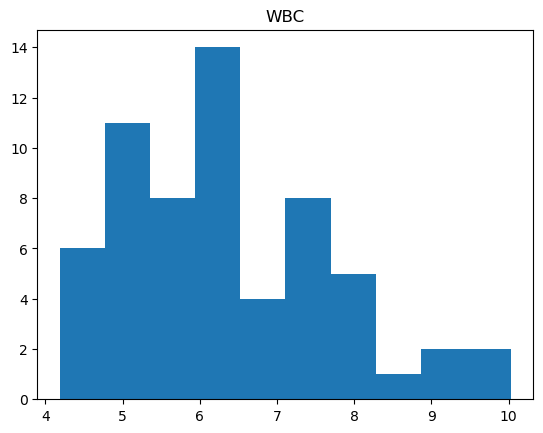

In [13]:
plt.hist(np.array(df[LABEL_NAME]))
plt.title(LABEL_NAME)
print(f'{LABEL_NAME} : ', 'min', df[LABEL_NAME].min(), 'median', df[LABEL_NAME].median(), 'max', df[LABEL_NAME].max())

min 4.19 median 6.25 max 9.32


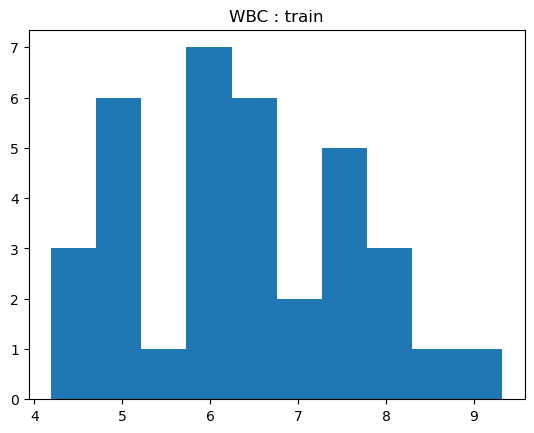

In [14]:
dataset_utils.plot_hist(df, tit=LABEL_NAME, dest='train')

min 4.23 median 6.06 max 8.89


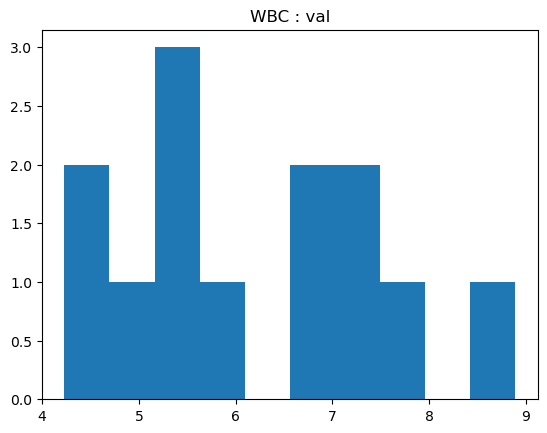

In [15]:
dataset_utils.plot_hist(df, tit=LABEL_NAME, dest='val')

min 4.69 median 6.12 max 10.03


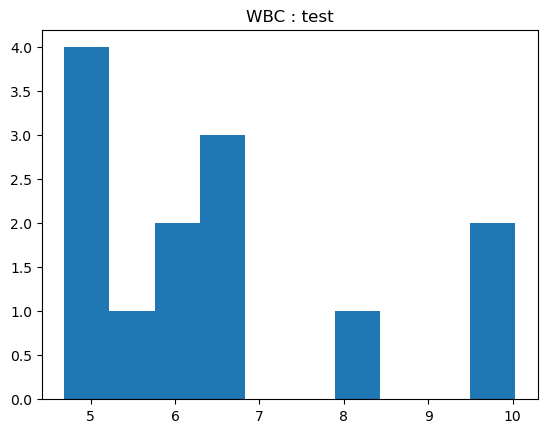

In [16]:
dataset_utils.plot_hist(df, tit=LABEL_NAME, dest='test')

In [17]:
"""
train_df = df[df.index.isin(all_train_indices)]
val_df = df[df.index.isin(all_val_indices)]
test_df = df[df.index.isin(all_test_indices)]
"""

train_df = df[df.index.isin(train_indices)]
val_df = df[df.index.isin(val_indices)]
test_df = df[df.index.isin(test_indices)]

In [18]:
train_df

,Gender,Age,is_smoking,BloodType_RHpos,BloodType_RHneg,BloodType,HCT,HGB,RBC,MCV,...,bottom left region,top central region,central region,bottom central region,top right region,central right region,bottom right region,Image_rating,Best_center_position_VertHor,Notes
0,Male,25,1.0,3,0,3,45.3,16.8,5.60,80.9,...,Image of a high quality of the secondary nailf...,Image of a medium quality of the secondary nai...,Image of a high quality of the mixed secondary...,Image of a high quality of the primary nailfol...,Image of a medium quality of the primary nailf...,Image of a high quality of the mixed primary n...,Nail zone; total rank is 2.,5.0,"500,700",NaN
2,Male,20,0.0,3,0,3,45.2,15.2,5.44,83.1,...,Image of a low sharpness of the secondary nail...,Image of a medium quality of the secondary nai...,Image of a medium quality of the secondary nai...,Image of a medium quality of the secondary nai...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,5.0,"500,700",NaN
5,Male,20,0.0,2,0,2,47.6,15.7,5.92,80.4,...,Image of a medium quality of the secondary nai...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a medium quality of the secondary nai...,Image of a high quality of the primary nailfol...,Image of a high quality of the mixed primary n...,Image of a medium quality of the primary nailf...,5.0,"500,700",NaN
6,Male,22,0.0,0,1,1,41.6,14.6,5.04,82.5,...,Image of a low sharpness of the secondary nail...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a medium sharpness of the primary nai...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,5.0,"300,700",NaN
9,Female,35,0.0,3,0,3,43.1,14.5,5.04,85.5,...,Image of a high quality of the secondary nailf...,Image of a medium quality of the secondary nai...,Image of a high quality of the mixed secondary...,Image of a high quality of the primary nailfol...,Image of a medium quality of the primary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the mixed primary n...,3.0,"500,700",NaN
10,Male,40,0.0,1,0,1,41.9,14.4,4.82,86.9,...,Image of a high quality of the primary nailfol...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the mixed primary n...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Nail zone; total rank is 2.,5.0,"500,500",NaN
13,Male,40,0.0,1,0,1,42.7,14.3,4.84,88.2,...,Image of a medium quality of the secondary nai...,Image of a low sharpness and brightness of the...,Image of a low brightness of the secondary nai...,Image of a medium quality of the secondary nai...,Image of a low sharpness and brightness of the...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,3.0,"500,700",NaN
15,Male,28,0.0,1,0,1,43.5,15.4,5.46,79.7,...,Image of a low sharpness of the secondary nail...,Image of a medium quality of the secondary nai...,Image of a medium quality of the secondary nai...,Image of a low sharpness of the primary nailfo...,Image of a medium quality of the primary nailf...,Image of a medium quality of the primary nailf...,Nail zone; total rank is 2.,2.0,"500,500",NaN
16,Male,27,0.0,3,0,3,44.9,15.6,5.46,82.2,...,Image of a high quality of the secondary nailf...,Image of a low sharpness of the secondary nail...,Image of a medium quality of the primary nailf...,Image of a high quality of the primary nailfol...,Image of a low sharpness of the primary nailfo...,Image of a low sharpness of the mixed primary ...,Nail zone; total rank is 2.,2.0,"700,500",NaN
18,Male,26,0.0,1,0,1,46.1,15.2,5.39,85.5,...,Image of a medium quality of the primary nailf...,Image of a lo

In [19]:
val_df

,Gender,Age,is_smoking,BloodType_RHpos,BloodType_RHneg,BloodType,HCT,HGB,RBC,MCV,...,bottom left region,top central region,central region,bottom central region,top right region,central right region,bottom right region,Image_rating,Best_center_position_VertHor,Notes
3,Male,50,0.0,1,0,1,44.5,15.0,5.00,89.0,...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the primary nailfo...,Image of a low sharpness of the primary nailfo...,Image of a low sharpness of the primary nailfo...,2.0,"500,700",bad_nailfold
7,Female,61,0.0,3,0,3,38.4,12.9,4.78,80.3,...,Image of a medium quality of the secondary nai...,Image of a medium quality of the mixed primary...,Image of a medium quality of the primary nailf...,Image of a low sharpness of the secondary nail...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,Image of a low sharpness of the mixed primary ...,3.0,"500,500",bad_nailfold
24,Male,23,0.0,0,0,0,41.1,14.4,5.00,82.2,...,Image of a low sharpness of the secondary nail...,Image of a medium sharpness of the secondary n...,Image of a high quality of the secondary nailf...,Image of a low sharpness of the secondary nail...,Nail zone; total rank is 2.,Image of a high quality of the mixed primary n...,Image of a low sharpness of the mixed primary ...,4.0,"500,500",NaN
34,Male,33,0.0,0,0,0,45.3,15.5,5.40,83.9,...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the secondary nailf...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,Image of a high quality of the mixed primary n...,5.0,"500,500",NaN
37,Female,20,0.0,0,1,1,39.5,13.1,4.65,84.9,...,Image of a high quality of the primary nailfol...,Image of a medium quality of the mixed seconda...,Image of a high quality of the primary nailfol...,Nail zone; total rank is 2.,Image of a medium quality of the primary nailf...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,3.0,"500,300",NaN
38,Male,29,0.0,1,0,1,47.9,16.4,5.68,84.3,...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,5.0,"500,700",NaN
54,Male,22,1.0,0,0,0,41.6,15.1,4.88,85.2,...,Image of a high quality of the secondary nailf...,Image of a medium quality of the primary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,Nail zone; total rank is 2.,5.0,"700,500",no_wrist
56,Male,20,0.0,1,0,1,42.8,14.9,4.92,87.0,...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,5.0,"500,700",NaN
57,Male,19,1.0,2,0,2,45.6,16.6,5.56,82.0,...,Image of a high quality of the secondary nailf...,Image of a low sharpness of the primary nailfo...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,Image of a high quality of the mixed primary n...,3.0,"500,500",NaN
59,Male,19,0.0,0,0,0,40.4,14.2,4.71,85.8,...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Nail zone; total rank is 2.,Nail 

In [20]:
test_df

,Gender,Age,is_smoking,BloodType_RHpos,BloodType_RHneg,BloodType,HCT,HGB,RBC,MCV,...,bottom left region,top central region,central region,bottom central region,top right region,central right region,bottom right region,Image_rating,Best_center_position_VertHor,Notes
1,Male,22,1.0,2,0,2,40.6,14.3,4.63,87.7,...,Image of a medium quality of the secondary nai...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the mixed primary n...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,5.0,"300,500",NaN
4,Female,21,0.0,1,0,1,35.3,12.3,4.03,87.6,...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,5.0,"500,700",NaN
11,Female,23,0.0,1,0,1,37.6,12.6,4.54,82.8,...,Image of a high quality of the secondary nailf...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,Image of a medium quality of the mixed primary...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,Image of a medium quality of the mixed primary...,4.0,"500,500",NaN
17,Male,24,1.0,2,0,2,47.9,17.1,5.46,87.7,...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the mixed primary ...,Image of a low sharpness of the mixed primary ...,Image of a low sharpness of the mixed primary ...,2.0,"500,500",NaN
20,Male,21,1.0,2,0,2,45.9,15.7,5.19,88.4,...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,5.0,"500,700",NaN
23,Male,21,1.0,0,0,0,42.0,15.2,4.99,84.2,...,Image of a low sharpness of the secondary nail...,Image of a high quality of the secondary nailf...,Image of a high quality of the secondary nailf...,Image of a medium quality of the secondary nai...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,5.0,"500,500",NaN
32,Female,27,1.0,0,0,0,39.3,13.6,4.37,89.9,...,Image of a high quality of the secondary nailf...,Image of a high quality of the primary nailfol...,Image of a high quality of the primary nailfol...,Image of a high quality of the secondary nailf...,Nail zone; total rank is 2.,Image of a high quality of the mixed primary n...,Image of a high quality of the mixed primary n...,3.0,"500,700",nailfold is not really good
33,Male,20,1.0,0,0,0,43.3,15.5,5.07,85.4,...,Image of a low sharpness of the secondary nail...,Image of a low sharpness of the mixed primary ...,Image of a high quality of the primary nailfol...,Image of a medium quality of the primary nailf...,Nail zone; total rank is 2.,Nail zone; total rank is 2.,Image of a low brightness of the primary nailf...,3.0,"700,500",NaN
45,Male,19,0.0,0,0,0,45.9,16.0,5.13,89.5,...,Image of a low sharpness of the primary nailfo...,Image of a low sharpness of the secondary nail...,Image of a high quality of the primary nailfol...,Image of a high quality of the mixed primary n...,Image of a medium quality of the primary nailf...,Image of a high quality of the mixed primary n...,Nail zone; total rank is 2.,3.0,"500,500",NaN
52,Male,22,0.0,2,0,2,45.1,15.3,5.68,79.4,...,Image of a high quality of the secondary nailf...,Image of a high quality of the mixed primary n...,Image of a high qual

In [19]:

# train_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, train_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH)

self.crops_coords[0] :
len() : 25
[{'x': 380, 'y': 377, 'white_px': 5225}, {'x': 419, 'y': 395, 'white_px': 5094}, {'x': 450, 'y': 372, 'white_px': 4879}, {'x': 433, 'y': 399, 'white_px': 4843}, {'x': 470, 'y': 399, 'white_px': 4736}, {'x': 281, 'y': 375, 'white_px': 4718}, {'x': 295, 'y': 409, 'white_px': 4597}, {'x': 310, 'y': 412, 'white_px': 4436}, {'x': 300, 'y': 360, 'white_px': 4394}, {'x': 530, 'y': 388, 'white_px': 4268}, {'x': 414, 'y': 442, 'white_px': 4234}, {'x': 558, 'y': 399, 'white_px': 4208}, {'x': 394, 'y': 308, 'white_px': 4074}, {'x': 57, 'y': 461, 'white_px': 3960}, {'x': 623, 'y': 379, 'white_px': 3952}, {'x': 545, 'y': 328, 'white_px': 3906}, {'x': 109, 'y': 447, 'white_px': 3904}, {'x': 9, 'y': 523, 'white_px': 3879}, {'x': 484, 'y': 418, 'white_px': 3842}, {'x': 629, 'y': 380, 'white_px': 3842}, {'x': 649, 'y': 376, 'white_px': 3789}, {'x': 419, 'y': 293, 'white_px': 3780}, {'x': 466, 'y': 292, 'white_px': 3742}, {'x': 102, 'y': 397, 'white_px': 3731}, {'x': 37

In [21]:
# 'RAW_FRAMES'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)

train_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, train_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH)# , transforms=transforms)
val_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, val_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH)# , transforms=transforms)
test_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, test_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH)# , transforms=transforms)

print(f'len(train_dataset), len(val_dataset), len(test_dataset) : {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}')
print(f'train_dataset.get_targets() : \n{train_dataset.get_targets().numpy()}')
print(f'val_dataset.get_targets() : \n{val_dataset.get_targets().numpy()}')
print(f'test_dataset.get_targets() : \n{test_dataset.get_targets().numpy()}')

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers=n_cpu)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, num_workers=n_cpu)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, num_workers=n_cpu)


len(train_dataset), len(val_dataset), len(test_dataset) : 41, 10, 10
train_dataset.get_targets() : 
[1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1
 1 0 1 0]
val_dataset.get_targets() : 
[0 0 1 1 1 1 0 0 0 0]
test_dataset.get_targets() : 
[0 0 0 0 0 1 1 0 1 1]


In [22]:

class EarlyStop:
    """Callback for early stop train process.

    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop
            when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.

    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
        steps (int): Number of passed epochs.
        best_step (int): Number of best epoch.
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """

    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.model = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999

    def start(self, history, model):
        """Start and init callback.

        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
            model (Model): Training model.
        """

        self.history = history
        self.model = model

    def step(self):
        """Make a step of callback.

        Returns:
            tuple: (event, stop):
                event (str): Description of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """

        self.steps += 1

        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps

        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False

    def stop(self):
        """Delete model from callback."""

        self.model = None
        torch.cuda.empty_cache()


class SaveBest:
    """Callback for save model if there is an improvement.

    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop
            when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.

    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
        steps (int): Number of passed epochs.
        best_step (int): Number of best epoch.
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """

    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.model = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999

    def start(self, history, model):
        """Start and init callback. Save first version of model.

        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values.
            model (Model): Training model
        """

        self.history = history
        self.model = model

        torch.save(self.model.state_dict(), self.model_path)

    def step(self):
        """Make a step of callback.

        Returns:
            tuple: (event, stop):
                event (str): Description of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """

        self.steps += 1

        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps

        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False

    def stop(self):
        """Delete model from callback."""

        self.model = None
        torch.cuda.empty_cache()


def plot_cm(model, loader, title):
    """Show confusion matrix for predictions of model on loader data.

    Args:
        model (Model): Model for predictions.
        loader (DataLoader): Loader with data.
        title (str): Title of CM.
    """

    plt.figure()

    with torch.no_grad():
        labels, preds = predict(loader, model)

    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, figsize=(2.5, 2.5), cmap=plt.cm.Blues)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title + " CM")
    plt.show()


def plot_train_history(history, metric_name):
    """Plot train history.

    Args:
        history (dict): Dict of lists with train history.
        metric_name (str): Name of metric.
    """

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(17, 10))

    ax[0].plot(history['Train loss'], c='r')
    ax[0].plot(history['Val loss'], c='g')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'])

    ax[1].plot(history[f'Train {metric_name}'], c='r')
    ax[1].plot(history[f'Val {metric_name}'], c='g')
    ax[1].set_title(metric_name)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].legend(['Train', 'Val'])

    plt.show()


def evaluate(model, loader, criterion, metric_fn):
    """Make model evaluation on loader data.

    Args:
        model (Model): Current model.
        loader (DataLoader): DataLoader with data for predictions.
        criterion (callable): Function for loss calculation.
        metric_fn (callable): Function for metric calculation.

    Returns:
        tuple: (loss, metric):
            loss (float): Value of loss.
            metric (float): Value of metric.
    """

    model.eval()

    labels_all = None
    outputs = None
    outputs_clean = None

    sm = torch.nn.Softmax(dim=1)

    for images, labels in iter(loader):
        if torch.cuda.is_available():
            images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = sm(model.forward(images)).argmax(1)

        output_clean = model.forward(images)
        if outputs is not None:
            outputs_clean = torch.cat((outputs_clean, output_clean.cpu()), 0)
            outputs = torch.cat((outputs, output.cpu()), 0)
            labels_all = torch.cat((labels_all, labels.cpu()), 0)
        else:
            outputs = output.cpu()
            outputs_clean = output_clean.cpu()
            labels_all = labels.cpu()

    model = None
    images = None
    labels = None
    output = None
    sm = None

    torch.cuda.empty_cache()

    return criterion(outputs_clean, labels_all), metric_fn(labels_all, outputs)


def predict(loader, model):
    """Make model predictions on loader data.

    Args:
        loader (DataLoader): DataLoader with data for predictions.
        model (Model): Current model.

    Returns:
        tuple: (act_classes, pred_classes):
            act_classes (list): List of actual classes.
            pred_classes (list): List of predicted classes.
    """

    model.eval()

    act_classes = None
    pred_classes = None

    sm = torch.nn.Softmax(dim=1)

    for images, labels in iter(loader):
        if torch.cuda.is_available():
            images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = sm(model.forward(images)).argmax(1)

        if act_classes is None:
            act_classes = labels.cpu()
            pred_classes = output.cpu()
        else:
            act_classes = torch.cat((act_classes, labels.cpu()))
            pred_classes = torch.cat((pred_classes, output.cpu()))

    model = None
    images = None
    labels = None
    output = None
    sm = None

    torch.cuda.empty_cache()

    return list(act_classes), list(pred_classes)

In [23]:
# Define model:

PATCH_SIZE = 128 # 64 # 28
EMBEDDING_DIM = 256 # 512
DEPTH = 6 # 8
NUM_HEADS = 8 # 16
HEAD_DIM = 64 # 128
MLP_DIM = 512 # 1024

model = ViViTModel2(img_size=TRANSFORM_RESIZE[0], in_channels=1, patch_size=PATCH_SIZE, embedding_dim=EMBEDDING_DIM, num_frames=VIDEO_LENGTH, depth=DEPTH, num_heads=NUM_HEADS, head_dim=HEAD_DIM, n_classes=2, mlp_dim=MLP_DIM, pool='cls', p_dropout=0.15, attn_dropout=0.15, drop_path_rate=0.15).to(DEVICE)


In [24]:
# Train model:

# Define the loss function and optimizer
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=DECAY)
sm = torch.nn.Softmax(dim=1)

#train_logs = {'accuracy': [], 'loss': []}
#valid_logs = {'accuracy': [], 'loss': []}

patience = int(NUM_OF_EPOCHS*0.05)
MIN_LR = 1e-4
factor = 0.5

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, min_lr=MIN_LR, factor=factor)
history = {'Train loss': [], f'Train {METRIC_NAME}': [], 'Val loss': [], f'Val {METRIC_NAME}': []}

print('\nTraining started!')

for e in range(NUM_OF_EPOCHS):
    print(f'\nEpoch: {e+1}')
    model.train()
    running_loss = 0
    running_accuracy = 0

    steps = 0

    for frames, label in iter(train_loader):
        steps += 1

        if torch.cuda.is_available():
            frames, labels = frames.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()
        output = model.forward(frames)
        #print(f'output.shape : {output.shape}, labels.shape : {labels.shape}')
        #print(f'output : {output}')
        #print(f'labels : {labels}')
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            running_loss += loss.item()
            probabilities = sm(output).argmax(dim=1).cpu()
            running_accuracy += METRIC_FN(labels.cpu(), probabilities)

    with torch.no_grad():
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, METRIC_FN)

    train_print = f'Train loss: {running_loss / steps}, Train {METRIC_NAME}: {running_accuracy / steps}, Val loss: {val_loss}, Val {METRIC_NAME}: {val_accuracy}\n'
    print(train_print)

    history['Train loss'].append(float(running_loss / steps))
    history[f'Train {METRIC_NAME}'].append(float(running_accuracy / steps))
    history['Val loss'].append(float(val_loss.item()))
    history[f'Val {METRIC_NAME}'].append(float(val_accuracy))

    if lr_scheduler:
        if 'OneCycleLR' in str(lr_scheduler):
            lr_scheduler.step()
        else:
            lr_scheduler.step(val_loss)

    """
    if callbacks:
        for i in callbacks:
            state_text, state = i.step()
            if state_text:
                train_print += ', ' + state_text
            if state:
                stop = True
    """
    torch.cuda.empty_cache()

print('\nTraining finished!\n')


Training started!

Epoch: 1


ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([1, 2]))

In [26]:
with torch.no_grad():
    loss, accuracy = evaluate(model, test_loader, criterion, METRIC_FN)
    print(f"Test loss: {loss}, Test {METRIC_NAME}: {accuracy}")

Test loss: 0.7344552874565125, Test Accuracy: 0.4


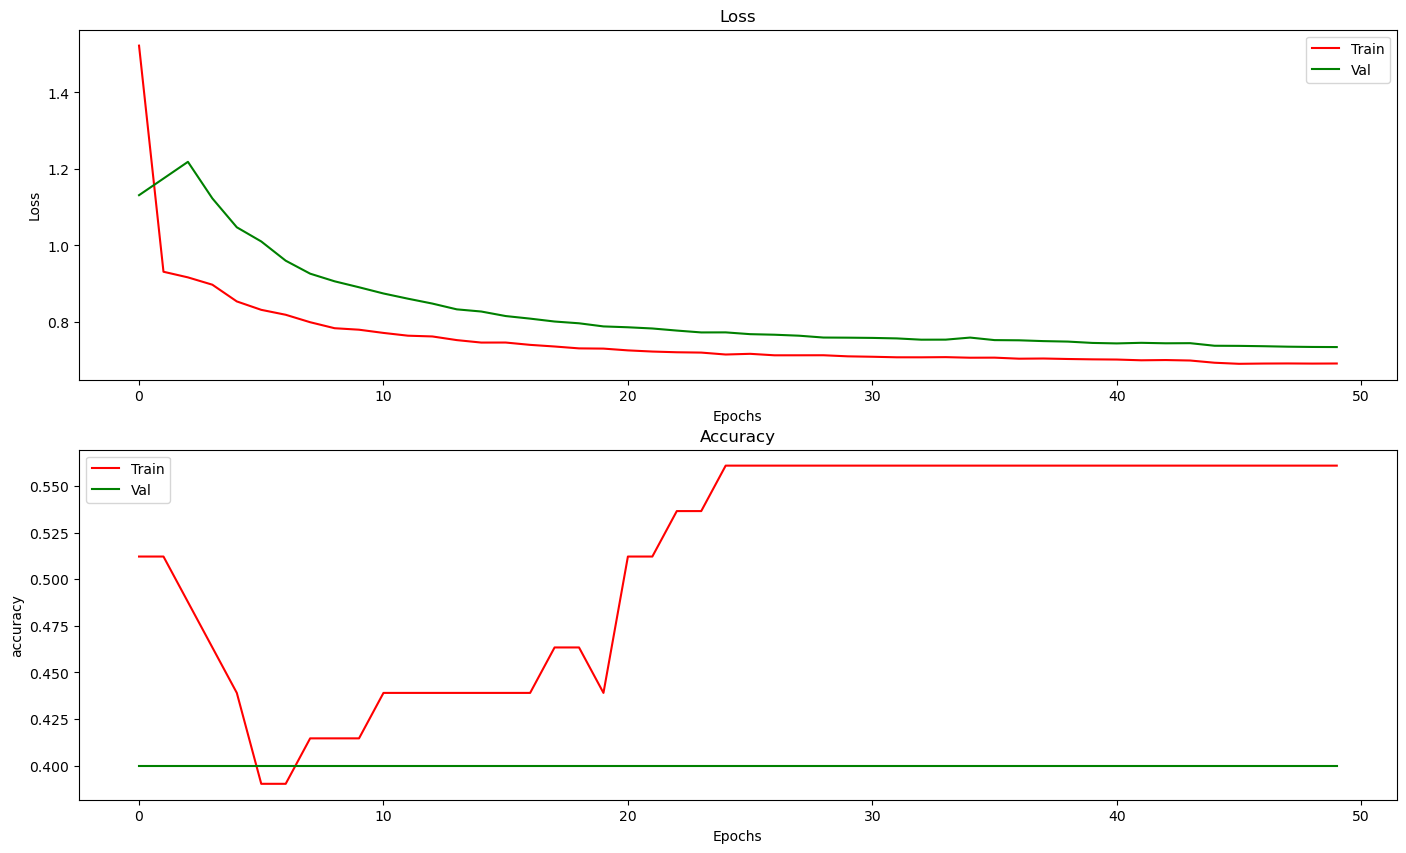

In [27]:
plot_train_history(history, METRIC_NAME)

<Figure size 640x480 with 0 Axes>

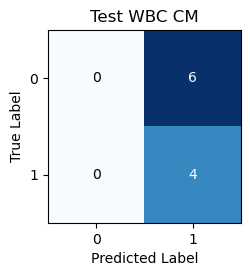

In [28]:
plot_cm(model, test_loader, title=f'Test {LABEL_NAME}')